In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf


https://storage.googleapis.com/tf-datasets/titanic/train.csv
https://storage.googleapis.com/tf-datasets/titanic/eval.csv

In [38]:
orignal_train = pd.read_csv("train.csv")
orignal_eval = pd.read_csv("eval.csv")

dftrain = pd.read_csv("train.csv")
dfeval = pd.read_csv("eval.csv")

target= orignal_train["survived"]
y_train = dftrain.pop("survived")   #Training data
y_eval = dfeval.pop("survived")     #Testing Data


In [39]:
orignal_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,survived
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n,0
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n,1
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y,1
3,female,35.0,1,0,53.1000,First,C,Southampton,n,1
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y,0


In [40]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [41]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [42]:
dftrain.shape

(627, 9)

In [43]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [44]:
# dftrain.age.hist(bin=20)

<Axes: ylabel='sex'>

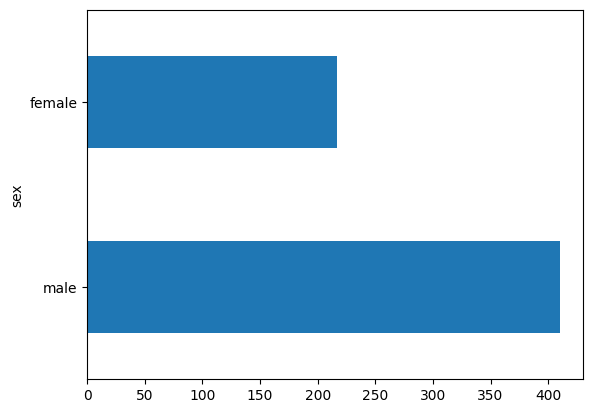

In [45]:
dftrain.sex.value_counts().plot(kind="barh")

<Axes: ylabel='class'>

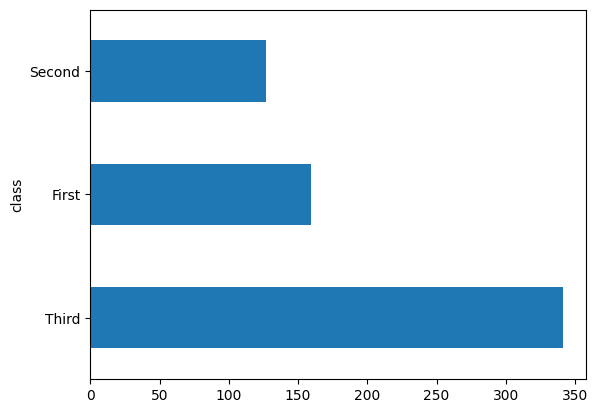

In [46]:
dftrain["class"].value_counts().plot(kind="barh")

Text(0.5, 0, 'Percentage survival')

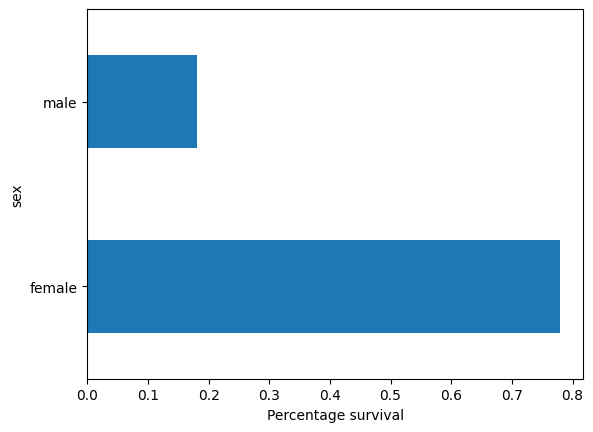

In [47]:
# how likely can a person survive based on sex:
pd.concat([dftrain, y_train], axis=1).groupby("sex").survived.mean().plot(kind="barh").set_xlabel("Percentage survival")

Selecting the Data:
-----------------

In [48]:
CAT_COL = ["sex", "n_siblings_spouses", "parch", "class", "deck", "embark_town", "alone"]
NUM_CAL = ["age", "fare"]

In [49]:
feature_col = []
for feature_name in CAT_COL:
    vocubulary = dftrain[feature_name].unique()
    feature_col.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocubulary))

for feature_name in NUM_CAL:
    feature_col.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))

In [50]:
categorical_inputs = {}
categorical_encoded = []
for feature_name in CAT_COL:
    vocab = [str(v) for v in dftrain[feature_name].unique()]
    input_layer = tf.keras.Input(shape=(1,), name=feature_name, dtype=tf.string)
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab)
    one_hot = tf.keras.layers.CategoryEncoding(
        num_tokens=lookup.vocabulary_size(), output_mode="one_hot"
    )(lookup(input_layer))

    categorical_inputs[feature_name] = input_layer
    categorical_encoded.append(one_hot)

numerical_inputs = {}
numerical_encoded = []
for feature_name in NUM_CAL:
    input_layer = tf.keras.Input(shape=(1,), name=feature_name, dtype=tf.float64)
    numerical_inputs[feature_name] = input_layer
    numerical_encoded.append(input_layer)



In [51]:
all_features = tf.keras.layers.concatenate(categorical_encoded + numerical_encoded)

In [52]:
print(all_features)

<KerasTensor shape=(None, 41), dtype=float32, sparse=False, ragged=False, name=keras_tensor_34>


Trainining process:
-----------

In [53]:
output = tf.keras.layers.Dense(1, activation="sigmoid")(all_features)
all_inputs = {**categorical_inputs, **numerical_inputs}

linear_model = tf.keras.Model(inputs=all_inputs, outputs=output)

In [54]:
linear_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [55]:
train_features = {name: dftrain[name].astype(str).values if name in CAT_COL else dftrain[name].values for name in CAT_COL + NUM_CAL}
train_labels = orignal_train["survived"].values

eval_features = {name: dfeval[name].astype(str).values if name in CAT_COL else dfeval[name].values for name in CAT_COL + NUM_CAL}
eval_labels = orignal_eval["survived"].values

In [56]:
linear_model.fit(train_features, train_labels, epochs=10, validation_data=(eval_features, eval_labels))

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6489 - loss: 2.2083 - val_accuracy: 0.6970 - val_loss: 1.6620
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6863 - loss: 1.6573 - val_accuracy: 0.6932 - val_loss: 1.5891
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6738 - loss: 1.8229 - val_accuracy: 0.6932 - val_loss: 1.5040
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6903 - loss: 2.1426 - val_accuracy: 0.6894 - val_loss: 1.4270
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6905 - loss: 1.6583 - val_accuracy: 0.6894 - val_loss: 1.3498
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6827 - loss: 1.7453 - val_accuracy: 0.6894 - val_loss: 1.2699
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6873 - loss: 1.4371 - val_accuracy: 0.6932 - val_loss: 1.1913
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6825 - loss: 1.4078 - val_accuracy: 0.6894 - val_loss

In [57]:
loss, accuracy = linear_model.evaluate(eval_features, eval_labels)
print("Accuracy:", accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6581 - loss: 1.0892 
Accuracy: 0.7121211886405945


In [58]:
probs = linear_model.predict(eval_features).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [59]:
print(dfeval.loc[0])
print(probs[10])

sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
0.102292836
